# Install dependencies

In [ ]:
!pip install contractions
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


# Library imports

In [ ]:
import re
import string
import contractions
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix

nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Data loading

In [ ]:
data = pd.read_csv("/content/Tweets.csv")

# Exploratory Data Analysis

In [ ]:
data.shape

(14640, 15)

In [ ]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

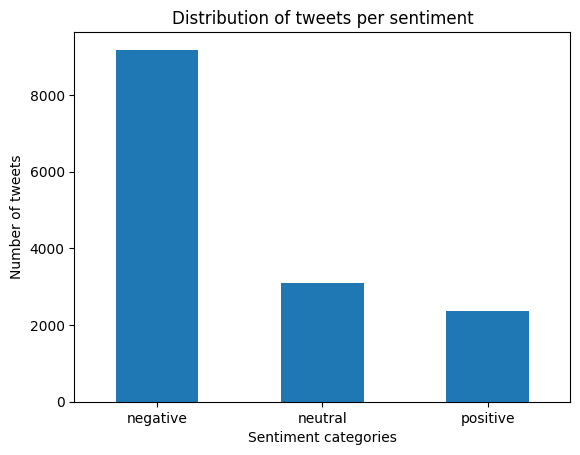

In [ ]:
data.airline_sentiment.value_counts().plot(kind='bar')
plt.title("Distribution of tweets per sentiment")
plt.xlabel("Sentiment categories")
plt.xticks(rotation=0)
plt.ylabel("Number of tweets")
plt.savefig(f"total_sentiments_per_category.png")

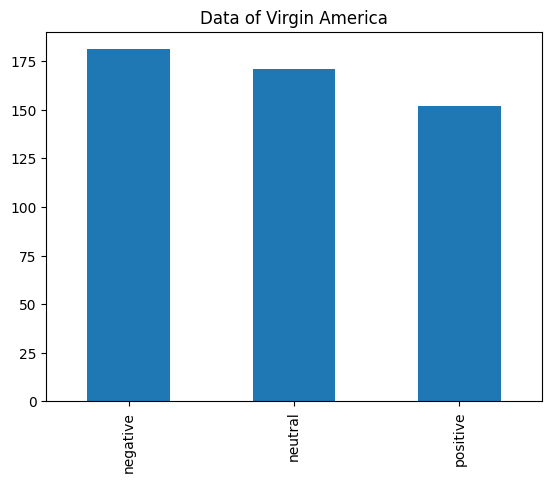

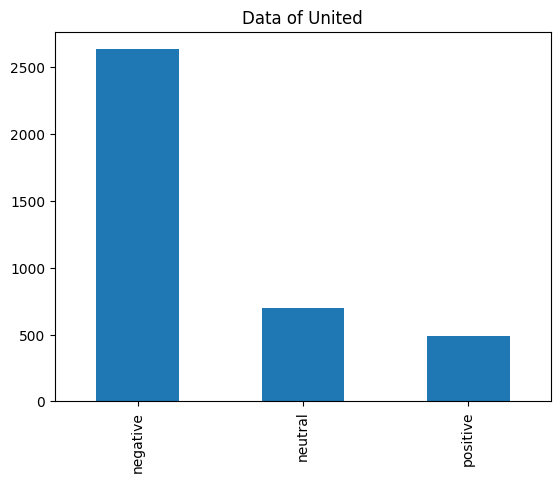

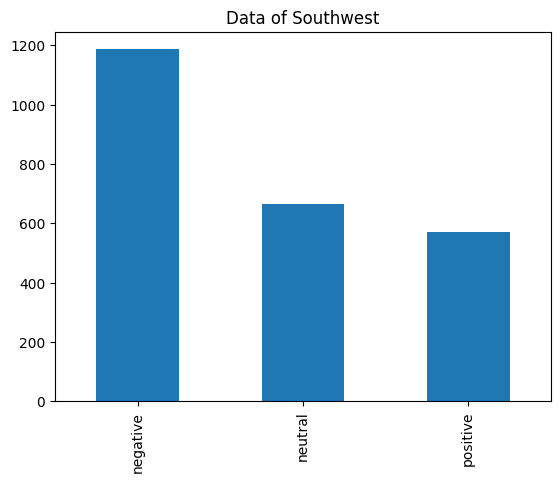

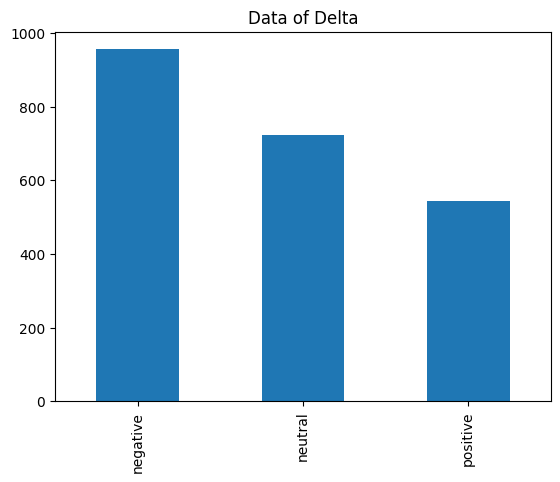

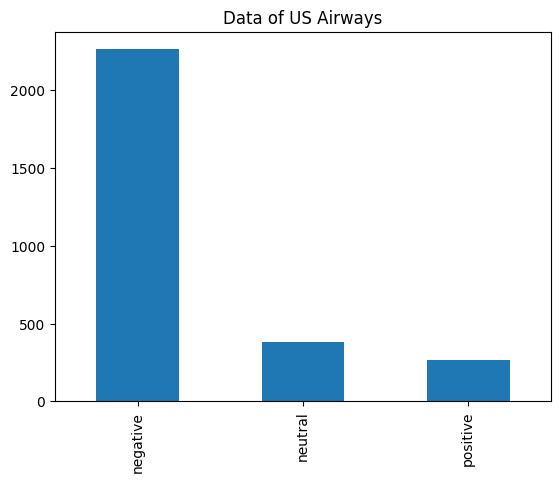

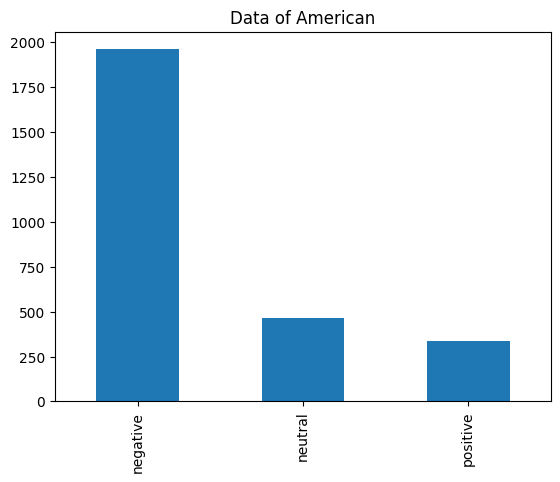

In [ ]:
for airline_name in data.airline.unique():
  data[data.airline == airline_name].airline_sentiment.value_counts().plot(kind='bar')
  plt.title(f"Data of {airline_name}")
  plt.show()

# Preprocessing

In [ ]:
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

In [ ]:
def remove_hashtags(text):
    return re.sub(r'#\w+', '', text)

In [ ]:
def remove_reserved_twitter_words(text):
    return re.sub(r'(rt|fav|via) @+', '', text)

In [ ]:
def remove_punctuations(text):
    clean = re.compile('&.*?;')
    text = re.sub(clean, '', text)
    return re.sub(r'[^\w\s]', '', text)

In [ ]:
def remove_hyperlinks(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in text if not w.lower() in stop_words]
    return filtered_sentence

In [ ]:
def fix_contractions(text):
    expanded_words = []   
    for word in text.split():
        expanded_words.append(contractions.fix(word))  
      
    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [ ]:
def apply_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatised_words = [lemmatizer.lemmatize(word, pos="v") for word in text.split()]
    return " ".join(lemmatised_words)

In [ ]:
def apply_stemming(text):
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in text]
    return " ".join(stemmed_words)


In [ ]:
def remove_digits(text):
    return ''.join(c for c in text if not c.isdigit())

In [ ]:
def preprocess(text):
    text = text.lower()

    text = fix_contractions(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = remove_reserved_twitter_words(text)

    text = remove_hyperlinks(text)
    text = remove_punctuations(text)
    text = remove_digits(text)

    text = nltk.word_tokenize(text)
    text = remove_stopwords(text)
 
    text = apply_stemming(text)
    text = apply_lemmatize(text)
    
    return text

In [ ]:
def calculate_sentiment_score(text):
    sent = SentimentIntensityAnalyzer()
    sentiment_score = sent.polarity_scores(str(text))
    if sentiment_score['compound'] >= 0.05:
        return 1
    elif sentiment_score['compound'] <= -0.05:
        return -1
    else:
        return 0

In [ ]:
data['processed_text'] = data['text'].apply(preprocess)

In [ ]:
data['sentiment_score'] = data['processed_text'].apply(calculate_sentiment_score)

In [ ]:
data['airline_sentiment'].replace({'positive': 1, 'neutral': 0, 'negative': -1}, inplace=True)

In [ ]:
data.head(20)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,processed_text,sentiment_score
0,570306133677760513,0,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),say,0
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plu ad commerci experi tacki,0
2,570301083672813571,0,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),today must mean need take anoth trip,0
3,570301031407624196,-1,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),realli aggress blast obnoxi entertain guest fa...,0
4,570300817074462722,-1,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),realli big bad thing,-1
5,570300767074181121,-1,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),serious would pay flight seat play realli bad ...,-1
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),ye nearli everi time fli vx ear worm go away,0
7,570300248553349120,0,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada),realli miss prime opportun men without hat parodi,-1
8,570299953286942721,1,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada),well notbut,1
9,570295459631263746,1,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada),amaz arriv hour earli good,1


<Axes: >

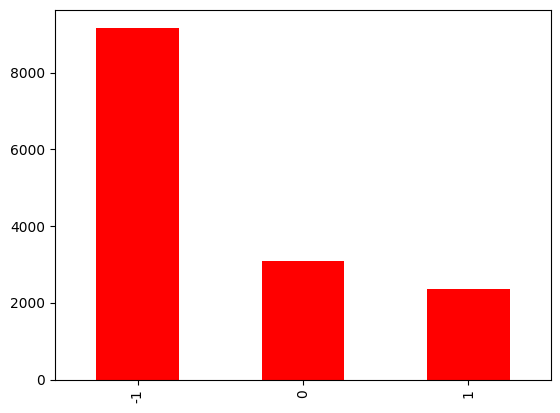

In [ ]:
data.airline_sentiment.value_counts().plot(kind='bar', color='red')

<Axes: >

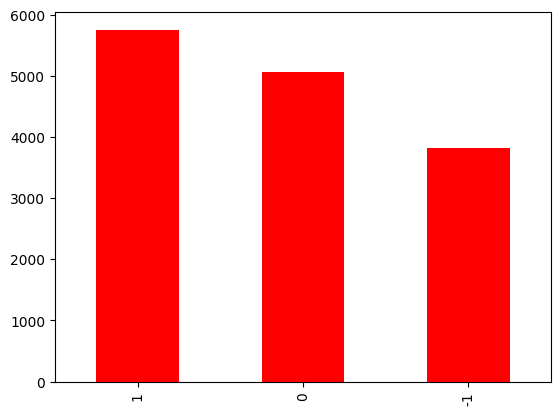

In [ ]:
data.sentiment_score.value_counts().plot(kind='bar', color='red')

# Confusion matrix

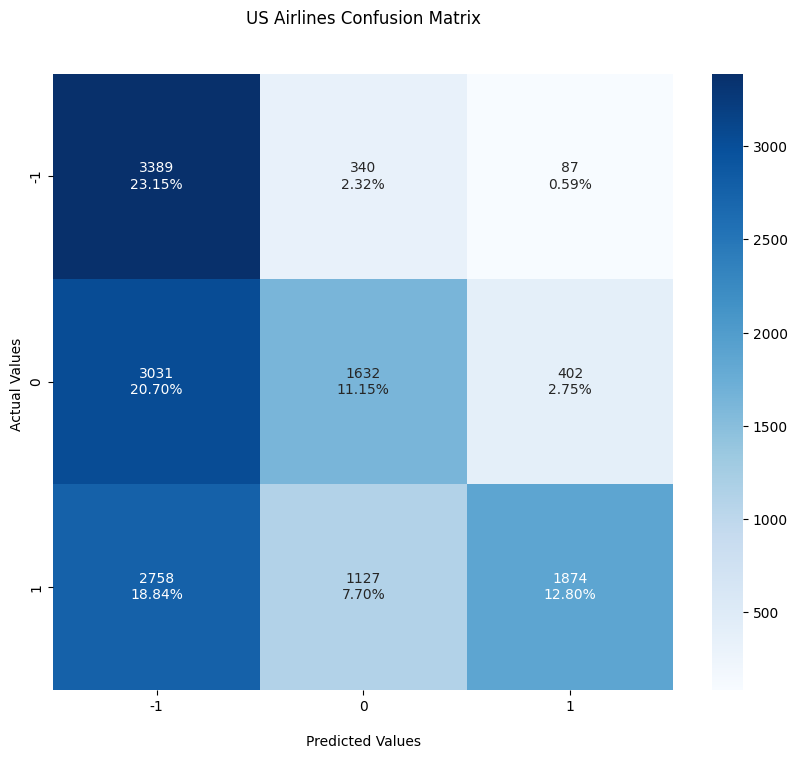

In [ ]:
cf_matrix = confusion_matrix(data['sentiment_score'], data['airline_sentiment'])

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts, group_percentages)]

labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize=(10,8))

sns_plot = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
sns_plot.xaxis.set_ticklabels([-1, 0, 1])
sns_plot.yaxis.set_ticklabels([-1, 0, 1])

sns_plot.set_title('US Airlines Confusion Matrix\n\n');
sns_plot.set_xlabel('\nPredicted Values')
sns_plot.set_ylabel('Actual Values ');

plt.show()
fig = sns_plot.get_figure()
fig.savefig(f"confusion_matrix.png")

N-Grams

In [ ]:
def generate_ngrams(text_list, size):
    ngram_tuples = []
    for text in text_list:
        ngram_tuples += list(nltk.ngrams(text.split(), size))
    ngram_freq = nltk.FreqDist(ngram_tuples)
    return ngram_freq

In [ ]:
def plot_ngrams(ngrams, type_name, bottom_size=0.30):
    plt.bar([str(ngram) for ngram, count in ngrams], [count for ngram, count in ngrams])
    plt.xticks(rotation=75)
    plt.xlabel(type_name)
    plt.ylabel('Frequency')
    plt.title(f'Top 10 {type_name} in Twitter data of US airlines')
    plt.subplots_adjust(bottom=bottom_size)
    plt.savefig(f"{type_name}.png")
    plt.show()

In [ ]:
processed_sentiments = data[data['sentiment_score'] == -1]["processed_text"]
print(processed_sentiments)

4                                     realli big bad thing
5        serious would pay flight seat play realli bad ...
7        realli miss prime opportun men without hat parodi
10                know suicid second lead death among teen
15                                sfopdx schedul still mia
                               ...                        
14618         overweight pull dozen passeng luggag serious
14626    flight nycbueno air delay sinc yesterday pm go...
14633    flight cancel flightl leav tomorrow morn auto ...
14634                                      right cue delay
14636    leav minut late flight warn commun minut late ...
Name: processed_text, Length: 3816, dtype: object


In [ ]:
unigrams = generate_ngrams(processed_sentiments, 1)

In [ ]:
top_unigrams = unigrams.most_common(10)
print(top_unigrams)

[(('flight',), 2059), (('delay',), 757), (('cancel',), 753), (('get',), 582), (('hour',), 434), (('flightl',), 382), (('servic',), 362), (('custom',), 332), (('miss',), 291), (('time',), 291)]


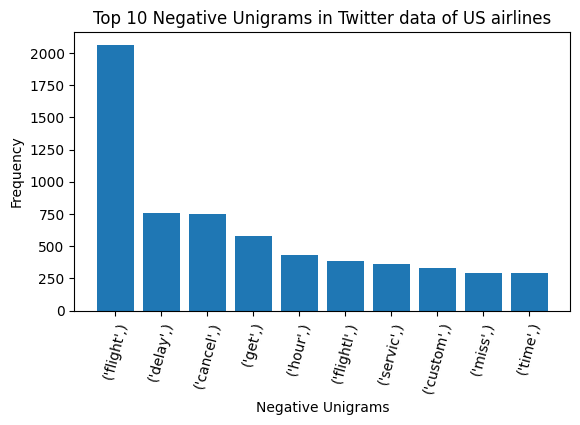

In [ ]:
plot_ngrams(top_unigrams, "Negative Unigrams")

In [ ]:
bigrams = generate_ngrams(processed_sentiments, 2)

In [ ]:
top_bigrams = bigrams.most_common(10)
print(top_bigrams)

[(('cancel', 'flightl'), 377), (('cancel', 'flight'), 306), (('custom', 'servic'), 219), (('flight', 'cancel'), 164), (('flight', 'delay'), 123), (('flight', 'flight'), 118), (('book', 'problem'), 105), (('flightl', 'flight'), 104), (('late', 'flight'), 94), (('miss', 'connect'), 85)]


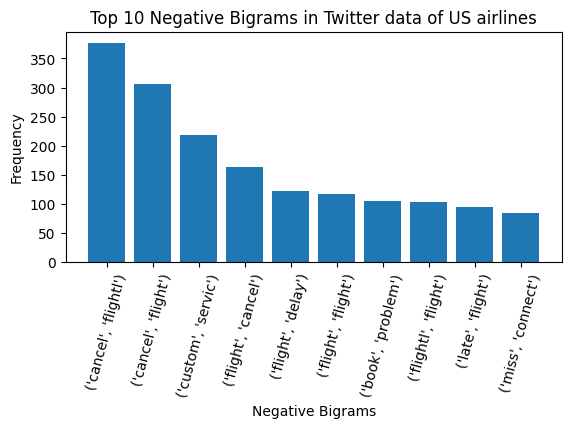

In [ ]:
plot_ngrams(top_bigrams, "Negative Bigrams", 0.4)

In [ ]:
trigrams = generate_ngrams(processed_sentiments, 3)

In [ ]:
top_trigrams = trigrams.most_common(10)
print(top_trigrams)

[(('cancel', 'flight', 'flight'), 109), (('flight', 'cancel', 'flightl'), 104), (('cancel', 'flightl', 'flight'), 102), (('flight', 'book', 'problem'), 66), (('flight', 'cancel', 'flight'), 49), (('worst', 'custom', 'servic'), 39), (('reflight', 'book', 'problem'), 35), (('poor', 'custom', 'servic'), 21), (('worst', 'airlin', 'ever'), 20), (('flight', 'delay', 'hour'), 18)]


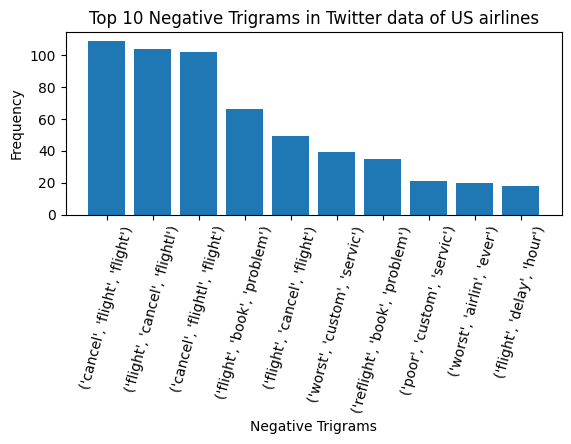

In [ ]:
plot_ngrams(top_trigrams, "Negative Trigrams", 0.5)